دانلود دیتاست و امبدینگ‌ها و ذخیره آن‌ها در درایو گوگل:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
#!unzip /content/glove.twitter.27B.zip -d /content/drive/MyDrive/NLP_UT/HW3/DS/

#!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
#!unzip /content/trainingandtestdata.zip -d /content/drive/MyDrive/NLP_UT/trainingandtestdata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


فراخوانی کتابخانه‌های مورد نیاز و تعریف مسیرهایی در حافظه که استفاده خواهند شد:

In [2]:
#!pip install clean-text[gpl]
#!pip install demoji
#import emoji
#import demoji
#from cleantext import clean
!pip install datasets
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import nltk
import re
import pickle
import string
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
dataset_dir = '/content/drive/MyDrive/NLP_UT/HW3/DS/training.1600000.processed.noemoticon.csv'
glove_dir = '/content/drive/MyDrive/NLP_UT/glove_twitter_27B/glove.twitter.27B.50d.txt'
test_dataset_dir = '/content/drive/MyDrive/NLP_UT/HW3/DS/testdata.manual.2009.06.14.csv'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.6 MB/s eta 0:00:00


<div dir='rtl'>
  خواندن دیتاست train و نمایش چند سطر آن (پس از حذف ستون‌های اضافه):
</div>

In [ ]:
print('train dataset: \n')
df = pd.read_csv(dataset_dir, names=["label", "0", "1", "2", "3", "text"], encoding= "ISO-8859-1")
df = df[['label', 'text']]
df.head()

train dataset: 



,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


نمایش کلاس‌های دیتاست و توزیع آن‌ها:

In [ ]:
np.unique(df['label'], return_counts = True)

(array([0, 4]), array([800000, 800000]))

انتخاب بخش کوچکی از دیتاست (30 درصد دیتاست) به صورت تصادفی و رعایت نسبت کلاس‌ها (و همینطور تغییر نام کلاس 4 به 1) و در نهایت چاپ نتیجه:

In [ ]:
labels = np.array([0 if i == 0 else 1 for i in df['label']])
corpus = np.array(df['text'])
class_size = int(0.15 * 1600000/2)
neg_indices = np.random.randint(0,1600000/2, size = class_size)
pos_indices = np.random.randint(1600000/2,1600000, size = class_size)
indices = np.concatenate((neg_indices, pos_indices))
labels = labels[indices]
corpus = corpus[indices]
del df, class_size, neg_indices, pos_indices
np.unique(labels, return_counts = True)

(array([0, 1]), array([120000, 120000]))

<div dir='rtl'>
  حال به دیتاست test می‌پردازیم: خواندن دیتاست test و نمایش کلاسهای مختلف آن:
</div>

In [ ]:
test_df = pd.read_csv(test_dataset_dir, names=["label", "0", "1", "2", "3", "text"], encoding= "ISO-8859-1")
test_df = test_df[['label', 'text']]
np.unique(test_df['label'], return_counts = True)

(array([0, 2, 4]), array([177, 139, 182]))

<div dir='rtl'>
  ظاهرا فایل test به روزرسانی شده است یا برای نسخه student دیتاست، که اینجا استفاده می‌کنیم، تهیه نشده است. دو راه وجود دارد:
  <ol>
    <li>
  	خروجی مدل‌ها را بر حسب اطمینان مدل بررسی می‌کنیم. یعنی اگر مدل داده‌ی ورودی را با درصد اطمینان (احتمال) بالاتر از مقدار خاصی (مثلا 75%) به کلاسی منتصب کند آن را جزو همان کلاس در نظر می‌گیریم. اگر مدل نتوانست با اطمینان مناسب داده را به هیچ یک از دو کلاس با برچسب 0 و 4 منتصب کند، آن‌ داده‌ی ورودی به کلاس با برچسب 2 منتصب می‌کنیم (البته یادآوری می‌گردد که بالاتر برچسب 4 را به مقدار 1 تغییر دادیم).
    </li>
    <li>
      داده‌های با برچسب 2 را از دیتاست test حذف می‌کنیم.
    </li>
    <li>
      داده‌های train را خود به دو بخش test و train تقسیم می‌کنیم. طبیعتا در این صورت از داده‌های test جدید برای آموزش مدل استفاده نخواهیم کرد.
    </li>
  </ol>
  برای این تمرین از روش سوم استفاده می‌کنیم.
</div>
<hr>

  تعریف تابعی جهت پیش پردازش و پاکسازی متن و سپس نمایش نتیجه‌ی پیش پردازش روی یکی از جمله‌های دیتاست:

In [ ]:
def customPreProccessing(text):    
  def all_dots(word):
    return (np.array([True if c == '.' else False for c in word]) == True).all()

  mini_stopwords = ['a', 'about', 'actually', 'almost', 'also', 'always', 'although', 'am',
 'an', 'and', 'are', 'as', 'at', 'be', 'become', 'became', 'by', 'can', 'could',
 'did', 'do', 'does', 'each', 'else', 'for', 'from', 'had', 'has', 'have', 'yet'
 'hence', 'how', 'i', 'he', 'she', 'you', 'your' ,'if', 'in', 'is', 'it', 'its', 
 'neither', 'just', 'may', 'maybe', 'me', 'might', 'mine', 'must', 'my', 'yes',
  'nor', 'oh', 'of', 'ok', 'when', 'where', 'whereas', 'wherever', 'whenever',
 'whether', 'which', 'while', 'who', 'whom', 'whoever', 'whose', 'why', 'will',
 'with', 'would', "'re", "'s","'m" '', '️', 'the'] #don't input 'we'
  
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]", flags=re.UNICODE)


  text = text.lower()    
  #remove emails
  text = re.sub('@[^\s]+', ' ', text)
  #remove urls
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
  #remove numbers
  text = re.sub('[0-9]+', '', text)  
  #remove letter repeat only if occured on last charachter     

  smile_emoctions = [':‑)', ':)',	':-]', ':]',	':->', ':>',	'8-)', '8)',	':-}', ':}', ':o)',	':c)',	':^)',	'=]',	'=)', ':-))', 
                     ':‑)', ':"D', ":')", ';‑)', ';D', ';)' ]
  laughing_emoctions = [':‑D', ':D', '8‑D', '8D',	'=D',	'=3',	'B^D',	'c:',	'C:', 'x‑D', 'xD',	'X‑D', 'XD']
  sad_emoctions = [":‑(", ":(",":‑c", ":c",	":‑<", ":<", ":‑[", ":[",	":-||",	":{",	":@",	":(",	";("]
  crying_emoctions = [":'‑(", ":'(	",":=("]  


  splited_text = nltk.tokenize.casual_tokenize(text)
  words = []
  for w in splited_text:
    if w == '' or w == '️':
      continue    
    if (w[0] == '@' or w[0] == '#'):
      continue
    if w in string.punctuation:
      continue
    if w in smile_emoctions: 
        words.append('smile')
    elif w in laughing_emoctions:
      words.append('laugh')
    elif w in sad_emoctions:
      words.append('sad')
    elif w in crying_emoctions:
      words.append('cry')
    elif emoji_pattern.match(w) != None:
      emoji2text = emoji.demojize(w, delimiters=('', ''))
      emoji2text = emoji2text.split('_')                    
      [words.append(e) for e in emoji2text]
    else:      
      more_tokenizing = nltk.word_tokenize(w)
      for t in more_tokenizing:
        if t[0] == '@' or t[0] == '#':
          continue
        if t in string.punctuation:
          continue                             
        if len(t) <= 1: #instead of 2
          continue 
        if all_dots(t):
          continue
        if t in mini_stopwords:
          continue
        words.append(t)

  return words 
print("original example: \n", corpus[114])
#print("\npre-processed example for one hot embedding: \n",' '.join(customPreProccessing(corpus[114], False)))
print("\npre-processed example for pretrained embedding: \n", ' '.join(customPreProccessing(corpus[114])))



original example: 
 @pcdmelodyt bye from aus 

pre-processed example for pretrained embedding: 
 bye aus


پیش پردازش و پاکسازی دیتاست با استفاده از تابع تعریف شده.

In [ ]:
text = []
for c in tqdm(corpus):  
  text.append(customPreProccessing(c))
text = np.array(text)
del corpus

  0%|          | 0/240000 [00:00<?, ?it/s]

<ipython-input-54-9279acbe91aa>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text = np.array(text)


نمایش چند داده از دیتاست پردازش شده.

In [3]:
#import pickle
#with open('/content/drive/MyDrive/text_135607_2.pkl', 'wb') as handle:
#    pickle.dump(text, handle)
#
#with open('/content/drive/MyDrive/labels_135607_2.pkl', 'wb') as handle:
#    pickle.dump(labels, handle)  
#
#fi = open('/content/drive/MyDrive/text_135607.pkl', 'rb')
#text = pickle.load(fi)
#
#fi = open('/content/drive/MyDrive/labels_135607.pkl', 'rb')    
#labels = pickle.load(fi)

text, labels
  

(array([list(['ya', "'ll", 'serious', 'too']), list(['cuzzo', 'called']),
        list(['wow', 'mins', 'after', 'posting', 'that', 'got', 'x-rays', 'lmfao']),
        ..., list(['happy', 'birthday']),
        list(['like', 'window', "'ve", 'got', 'there', 'to', 'left']),
        list(['desperate', 'housewives', 'approximately', 'ten', 'minutes'])],
       dtype=object),
 array([0, 0, 0, ..., 1, 1, 1]))

تقسیم بندی به test و train:

In [4]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.10, shuffle=True)

<div dir='rtl'>
  ساخت bag of words  و دیکشنری جهت ذخیره ایندکس هر کلمه (و یک آرایه  جهت دریافت کلمه متناظر با هر ایندکس):
</div>

In [5]:
bag_of_words, bag_of_counts = np.unique([w for tweet in X_train for w in tweet], return_counts = True)
bag_of_words = bag_of_words.tolist()
bag_of_counts = bag_of_counts.tolist()

new_rows = []
for idx, i in enumerate(bag_of_counts):
  if i > 2:
    new_rows.append(idx)
bag_of_counts = [bag_of_counts[i] for i in new_rows]
bag_of_words = [bag_of_words[i] for i in new_rows]
del new_rows

bag_of_words = np.array(bag_of_words)
bag_of_counts = np.array(bag_of_counts)
#insert padding and unkown
bag_of_words = np.insert(bag_of_words, 0, '<pad>')
bag_of_words = np.insert(bag_of_words, 1, '<unk>')
bag_of_counts = np.insert(bag_of_counts, 0, -1)
bag_of_counts = np.insert(bag_of_counts, 1, -1)
##

bag_of_words_dict = dict()
for idx, i in enumerate(bag_of_words):
  bag_of_words_dict[i] = idx

<div dir='rtl'>
  خواندن امبدینگ glove با ابعاد به اندازه 50:
</div>

In [6]:
glove_embedding = dict()
glove_dir = '/content/drive/MyDrive/NLP_UT/glove_twitter_27B/glove.twitter.27B.50d.txt'
with open(glove_dir, 'rb') as file:
  for line in tqdm(file):
    vector = line.split()
    word, embedding = vector[0].decode('utf-8'), np.asarray(vector[1:], 'float32')        
    glove_embedding[word] = embedding
file.close()

bag_of_words_glove_embedding = np.zeros((len(bag_of_counts), 50))
for idx, t in tqdm(enumerate(text)):
  for w in t:    
    #print(bag_of_words_dict[w])
    embedding = glove_embedding.get(w, None)
    index = bag_of_words_dict.get(w, None)
    #print(embedding, index)
    if not(embedding is None or index is None):
      bag_of_words_glove_embedding[bag_of_words_dict[w]] = embedding
#UNK embed      
bag_of_words_glove_embedding[1] = bag_of_words_glove_embedding[1] + 1
bag_of_words_glove_embedding = torch.tensor(bag_of_words_glove_embedding,dtype=torch.float , device='cpu')
bag_of_words_glove_embedding


j = 0
mean = np.zeros(50)
for i in tqdm(bag_of_words_glove_embedding[2:]):
  if not (i == 0).all():        
    mean += i.numpy()
    j+=1
mean = mean/j
unk_vec = mean

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/24177 [00:00<?, ?it/s]

<div dir = 'rtl'>
  ساخت امبدینگ word2vec با اندازه 50 بعد برای هر عدد (سایر موارد در گزارش آمده‌اند) و نمایش سه کلمه‌ی نزدیک به 'hi':
</div>

In [7]:
W2V_model = Word2Vec(sentences=text, vector_size=50, window=5, min_count=1, workers=2)
print("three most similar word to 'hi' based on trained WORD2VEC embedding: \n",W2V_model.wv.most_similar('hi', topn=3), '\n')
bag_of_words_w2v_embedding = np.zeros((len(bag_of_counts), 50))
w2v_vocs = W2V_model.wv.index_to_key
w2v_vocs = {i:idx for idx, i in enumerate(w2v_vocs)}
#for idx, t in tqdm(enumerate(text)):
#  for w in t:    
#    #print(bag_of_words_dict[w])
#    if w2v_vocs.get(w, -1) != -1:
#      embedding = W2V_model.wv[w]
#    else: 
#      embedding = None
#    index = bag_of_words_dict.get(w, None)
#    #print(embedding, index)
#    if not(embedding is None or index is None):
#      bag_of_words_w2v_embedding[index] = embedding
##UNK embed      
#bag_of_words_w2v_embedding[1] = bag_of_words_w2v_embedding[1] + 1
#bag_of_words_w2v_embedding = torch.tensor(bag_of_words_w2v_embedding, device='cuda', requires_grad=True)

#del w2v_vocs
#del W2V_model

three most similar word to 'hi' based on trained WORD2VEC embedding: 
 [('hey', 0.8557063937187195), ('hello', 0.8511402010917664), ('tom', 0.7707248330116272)] 



تعریف کلاس‌های دیتاست متناسب با هر امبدینگ و سپس ساخت دیتاست و دیتالودر برای  امبدینگ‌های مختلف:

In [8]:
class create_dataset(Dataset):
    def __init__(self, text, label, max_len): #, one_hot_len = None):
        self.text = text
        self.label = label        
        self.max_len = max_len
  
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):      
      output = []
      for idx, word in enumerate(self.text[index]):                        
        embed = glove_embedding.get(word, None)               
        if embed is None:
          embed = unk_vec                                  
        output.append(embed)
      padding_size = self.max_len - len(output)
      for _ in range(padding_size):
        output.append(np.zeros((50))) 
      output = np.array(output[0:max_len])       
      output = torch.tensor(output, requires_grad = True)         
      return output, self.label[index]   


class create_dataset_w2v(Dataset):
    def __init__(self, text, label, max_len): #, one_hot_len = None):
        self.text = text
        self.label = label        
        self.max_len = max_len
  
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):      
      output = []
      for idx, word in enumerate(self.text[index]):          
        if not (w2v_vocs.get(word, None) is None):
          output.append(W2V_model.wv[word])
        else:
          output.append(np.zeros((50)))                                   
      padding_size = self.max_len - len(output)
      for _ in range(padding_size):
        output.append(np.zeros((50))) 
      output = np.array(output[0:max_len])       
      output = torch.tensor(output, requires_grad = True)         
      return output, self.label[index]    

class create_one_hot_dataset(Dataset):
    def __init__(self, text, label, max_len): #, one_hot_len = None):
        self.text = text
        self.label = label        
        self.max_len = max_len
  
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
      output = np.array([])
      for idx, i in enumerate(self.text[idx]):
        word_idx = bag_of_words_dict.get(i, 1) #1 for unk
        output = np.append(output, word_idx)
      padding_size = np.zeros((self.max_len) - len(output)) #0 for pad
      output = np.append(output, padding_size)
      return torch.tensor(output, dtype=torch.int64), self.label[idx]      

In [ ]:
#next(iter(oh_test_dataloader))[0].shape

In [9]:
max_len = np.max([len(i) for i in X_train])
##GLOVE
train_dataset = create_dataset(X_train, y_train, max_len) #, np.max([len(i) for i in text]) )
test_dataset = create_dataset(X_test, y_test, max_len) #, np.max([len(i) for i in text]))
train_dataloader = DataLoader(train_dataset, batch_size=64 , shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

##W2V
w2v_train_dataset = create_dataset_w2v(X_train, y_train, max_len) #, np.max([len(i) for i in text]) )
w2v_test_dataset = create_dataset_w2v(X_test, y_test, max_len) #, np.max([len(i) for i in text]))
w2v_train_dataloader = DataLoader(w2v_train_dataset, batch_size=64 , shuffle=True)
w2v_test_dataloader = DataLoader(w2v_test_dataset, batch_size=64, shuffle=True)

##ONEHOT
oh_train_dataset = create_one_hot_dataset(X_train, y_train, max_len) #, np.max([len(i) for i in text]) )
oh_test_dataset = create_one_hot_dataset(X_test, y_test, max_len) #, np.max([len(i) for i in text]))
oh_train_dataloader = DataLoader(oh_train_dataset, batch_size=64 , shuffle=True)
oh_test_dataloader = DataLoader(oh_train_dataset, batch_size=64, shuffle=True)


<div dir='rtl'>
  تعریف کلاس مدل مبتنی بر RNN ساده (با پشتیبانی از معماری‌های ذکر شده در سوال برای ابمیدنگ‌های مختلف)
</div>

In [ ]:
class rnn_sentimentor(nn.Module):
    def __init__(self, num_inputs, one_hot = False):
        super().__init__()          
        self.one_hot = one_hot
        if one_hot:
          self.embedding = nn.Embedding(num_inputs, 150)                  
          self.rnn = nn.RNN(150, 50,num_layers =2, bidirectional = True , batch_first = True)
        else:
          #self.linear0 = nn.Linear(50, 150)                
          self.rnn = nn.RNN(num_inputs, 50,num_layers =2, bidirectional = True , batch_first = True)
        self.linear = nn.Linear(100, 32)                
        self.act_fn1 = nn.Sigmoid()
        self.linear2 = nn.Linear(32, 2)                
    def forward(self, x):                                           
        if self.one_hot:
          x = self.embedding(x)
        x = x.type(torch.float)                               
        _, x = self.rnn(x) #INPUT: OUTPUT:
        #if not self.one_hot:
        x = torch.cat((x[2,:,:],x[3,:,:]) , dim = 1)
        x = self.linear(x)
        x = self.act_fn1(x)
        x = self.linear2(x)                
        return x

<div dir='rtl'>
  تعریف کلاس مدل مبتنی بر RNN های LSTM و GRU (با پشتیبانی از معماری‌های ذکر شده در سوال برای ابمیدنگ‌های مختلف)
</div>

In [10]:
class rnn_plus_sentimentor(nn.Module):
    def __init__(self, num_inputs,rnn_type = 'LSTM', one_hot = False):
        super().__init__()          
        self.one_hot = one_hot
        self.rnn_type = rnn_type   
        if rnn_type == 'LSTM':
          rnn_type_net = nn.LSTM
        else:
          rnn_type_net = nn.GRU
        if one_hot:
          self.embedding = nn.Embedding(num_inputs, 150)                  
          self.rnn = rnn_type_net(150, 50,num_layers =2, bidirectional = True , batch_first = True)
        else:
          #self.linear0 = nn.Linear(50, 150)     
          self.rnn = rnn_type_net(num_inputs, 50,num_layers =2, bidirectional = True , batch_first = True)        
        self.linear = nn.Linear(100, 32)                
        self.act_fn1 = nn.Sigmoid()
        self.linear2 = nn.Linear(32, 2)                
    def forward(self, x):                                           
        if self.one_hot:
          x = self.embedding(x)
        x = x.type(torch.float)                               
        if self.rnn_type == 'LSTM':
          _, (x, _) = self.rnn(x)
        else:
          _, x = self.rnn(x) #INPUT: OUTPUT:
        #if not self.one_hot:
        x = torch.cat((x[2,:,:],x[3,:,:]) , dim = 1)
        x = self.linear(x)
        x = self.act_fn1(x)
        x = self.linear2(x)                
        return x

<div dir='rtl'>
  تعریف دو تابع آموزش (train) و تست مدل‌ها:
<div>

In [11]:
def train(model , optimizer , loss_fn , train_loader  , test_loader , epochs , device, req_grad = True):
  model.to(device)
  loss_fn.to(device)
  for epoch in range(epochs):
    training_loss = 0.0
    model.train()
    t_labels = []
    t_preds = []
    for X,y in tqdm(train_loader):                  
      t_labels+=y.numpy().tolist()      
      preds = model(nn.Parameter(X.to(device), requires_grad = req_grad))      
      loss = loss_fn(preds , y.to(device))      
      optimizer.zero_grad()      
      loss.backward()
      optimizer.step()      
      training_loss += loss.item()      
      t_preds += preds.argmax(axis=1).cpu().numpy().tolist()      
      #a,b,c = t_preds, preds, y
      #print(t_preds)
    training_loss = training_loss / len(train_loader)
    train_accuracy =  accuracy_score(t_labels, t_preds, normalize=True)
    print('Epoch: {} ,training loss: {:.2f} , train accuracy: {:.2f} '.format(epoch , training_loss ,train_accuracy))
  #test_loss , test_accuracy = validation(model , test_loader , loss_fn , device  )
  #print('test loss: {:.2f}  test accuracy: {:.2f}'.format( test_loss , test_accuracy))



import matplotlib.pyplot as plt
from sklearn import metrics
def validation( model , val_loader , loss_fn , device = "cuda"  ):
  val_loss = 0.0
  model.eval()
  reals = []
  preds_list = []
  for X,y in tqdm(val_loader):
    reals += y.numpy().tolist()
    with torch.no_grad():
      preds = model(X.to(device))
    loss = loss_fn(preds , y.to(device))
    val_loss += loss.item()    
    preds_list += preds.argmax(axis=1).cpu().numpy().tolist()

  val_loss = val_loss / len(val_loader)
  accuracy = accuracy_score(reals, preds_list, normalize=True)
  confusion_matrix = metrics.confusion_matrix(reals, preds_list)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])    
  print(classification_report(reals , preds_list ))
  cm_display.plot()
  plt.show()  
  #return reals, preds_list


<h3 align = 'center'>در ادامه مدل‌های خواسته شده در سوال را بررسی می‌کنیم. ابتدا مدل آموزش میابد، سپس بر روی داده‌ی تست ارزیابی می‌گردد و متریک‌های مختلف به نمایش گذاشته میشوند و در انتها خلاصه معماری مدل میآید.. با توجه به بخش 1 و 2 سوال، در مجموع 7 مدل خواهیم داشت.</h3>

model #1: simple RNN - Glove embedding

In [ ]:
glove_model = rnn_sentimentor(50)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(glove_model.parameters(), lr=0.01) 
loss_fn = nn.CrossEntropyLoss()

train(glove_model , optimizer , loss_fn , train_dataloader  , test_dataloader , epoch , device )

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.60 , train accuracy: 0.67 


  0%|          | 0/375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.52      0.61     11959
           1       0.63      0.82      0.72     12041

    accuracy                           0.67     24000
   macro avg       0.69      0.67      0.67     24000
weighted avg       0.69      0.67      0.67     24000



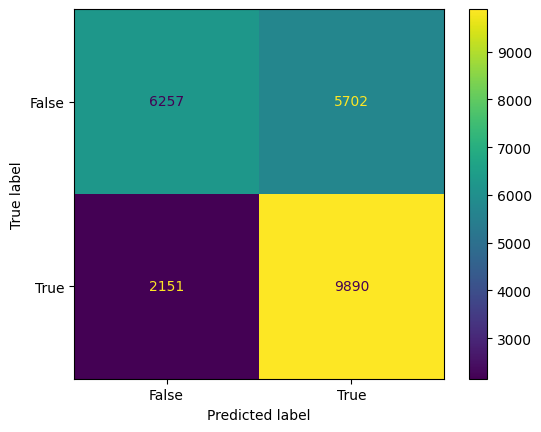

In [ ]:
validation(glove_model , test_dataloader , loss_fn , device  )

In [ ]:
print(glove_model)

rnn_sentimentor(
  (rnn): RNN(50, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


model #2: simple RNN - W2V embedding

In [ ]:
w2v_model = rnn_sentimentor(50)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(w2v_model.parameters(), lr=0.01) 
loss_fn = nn.CrossEntropyLoss()

train(w2v_model , optimizer , loss_fn , w2v_train_dataloader  , w2v_test_dataloader , epoch , device )

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.61 , train accuracy: 0.67 


  0%|          | 0/375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.63      0.81      0.71     11959
           1       0.73      0.52      0.61     12041

    accuracy                           0.66     24000
   macro avg       0.68      0.67      0.66     24000
weighted avg       0.68      0.66      0.66     24000



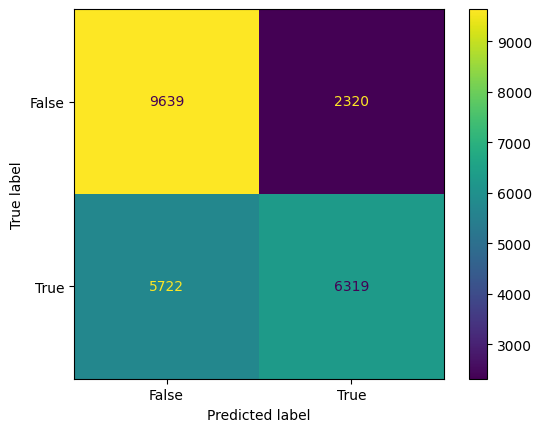

In [ ]:
validation(w2v_model , w2v_test_dataloader , loss_fn , device  )

In [ ]:
print(w2v_model)

rnn_sentimentor(
  (rnn): RNN(50, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


model #3: simple RNN - ONE HOT embedding

In [ ]:
oh_model = rnn_sentimentor(len(bag_of_words), True)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(oh_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train(oh_model , optimizer , loss_fn , oh_train_dataloader  , oh_test_dataloader , epoch , device, False)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.22 , train accuracy: 0.91 


  0%|          | 0/3375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.76      0.98      0.86    156867
           1       0.82      0.18      0.30     59133

    accuracy                           0.76    216000
   macro avg       0.79      0.58      0.58    216000
weighted avg       0.78      0.76      0.70    216000



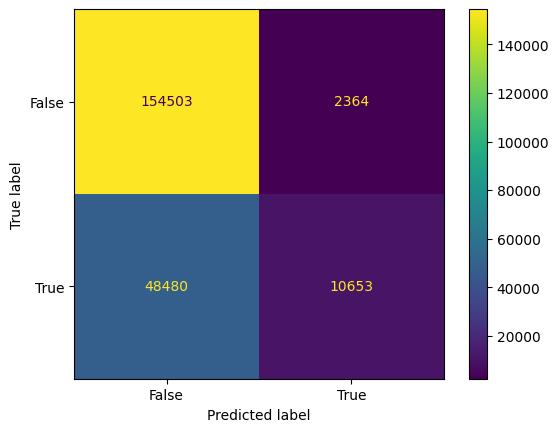

In [ ]:
validation(oh_model , oh_test_dataloader , loss_fn , device )

In [ ]:
print(oh_model)

rnn_sentimentor(
  (embedding): Embedding(24137, 150)
  (rnn): RNN(150, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


<H3 align='center'>بخش دوم</H3>

model #4: LSTM - ONE HOT embedding

In [ ]:
oh_model_lstm = rnn_plus_sentimentor(len(bag_of_words),'LSTM', True)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(oh_model_lstm.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train(oh_model_lstm , optimizer , loss_fn , oh_train_dataloader  , oh_test_dataloader , epoch , device, False)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.04 , train accuracy: 0.98 


  0%|          | 0/3375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    156867
           1       0.99      1.00      0.99     59133

    accuracy                           1.00    216000
   macro avg       1.00      1.00      1.00    216000
weighted avg       1.00      1.00      1.00    216000



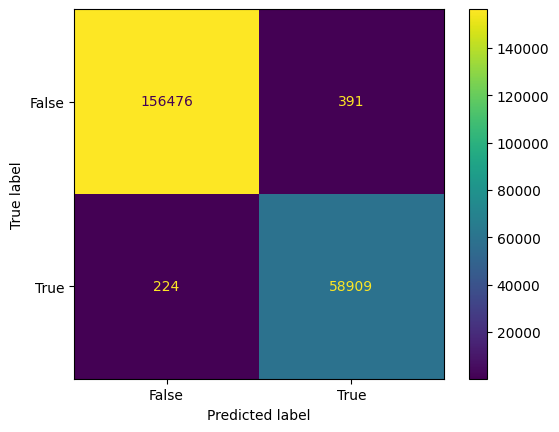

In [ ]:
validation(oh_model_lstm , oh_test_dataloader , loss_fn , device )

In [ ]:
print(oh_model_lstm)

rnn_plus_sentimentor(
  (embedding): Embedding(24137, 150)
  (rnn): LSTM(150, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


model #5: GRU - ONE HOT embedding

In [ ]:
oh_model_gru = rnn_plus_sentimentor(len(bag_of_words),'GRU', True)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(oh_model_gru.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train(oh_model_gru , optimizer , loss_fn , oh_train_dataloader  , oh_test_dataloader , epoch , device, False)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.20 , train accuracy: 0.90 


  0%|          | 0/3375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.96      0.93    156867
           1       0.87      0.76      0.81     59133

    accuracy                           0.90    216000
   macro avg       0.89      0.86      0.87    216000
weighted avg       0.90      0.90      0.90    216000



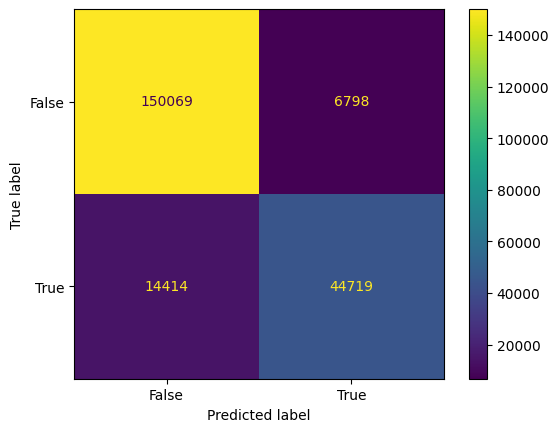

In [ ]:
validation(oh_model_gru , oh_test_dataloader , loss_fn , device)

In [ ]:
print(oh_model_gru)

rnn_plus_sentimentor(
  (embedding): Embedding(24137, 150)
  (rnn): GRU(150, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


model #6: LTSM - GloVe embedding

In [ ]:
glove_model_lstm = rnn_plus_sentimentor(50,'LSTM', False)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(glove_model_lstm.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train(glove_model_lstm , optimizer , loss_fn , train_dataloader  , test_dataloader , epoch , device, False)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.47 , train accuracy: 0.78 


  0%|          | 0/3375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.82      0.78      0.80    108041
           1       0.79      0.82      0.81    107959

    accuracy                           0.80    216000
   macro avg       0.80      0.80      0.80    216000
weighted avg       0.80      0.80      0.80    216000



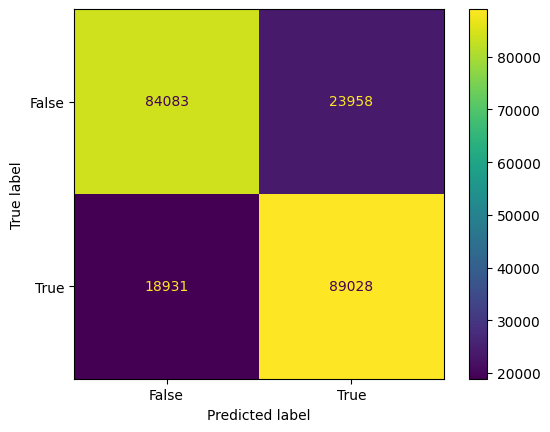

In [ ]:
validation(glove_model_lstm , train_dataloader , loss_fn , device)

In [ ]:
print(glove_model_lstm)

rnn_plus_sentimentor(
  (rnn): LSTM(50, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)


model #7: GRU - GLOVE embedding

In [12]:
glove_model_gru = rnn_plus_sentimentor(50,'GRU', False)
epoch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(glove_model_gru.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

train(glove_model_gru , optimizer , loss_fn , train_dataloader  , test_dataloader , epoch , device, False)

  0%|          | 0/3375 [00:00<?, ?it/s]

Epoch: 0 ,training loss: 0.48 , train accuracy: 0.77 


  0%|          | 0/3375 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    108007
           1       0.82      0.74      0.78    107993

    accuracy                           0.79    216000
   macro avg       0.79      0.79      0.79    216000
weighted avg       0.79      0.79      0.79    216000



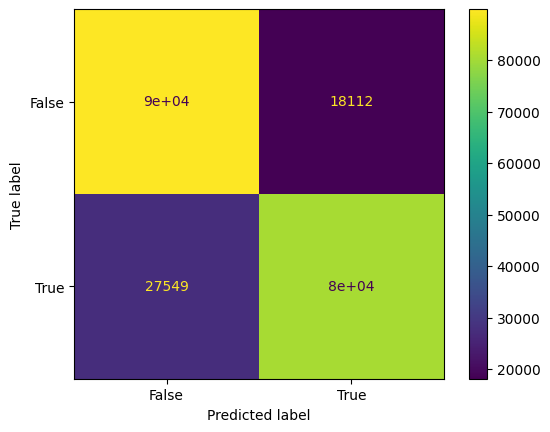

In [13]:
validation(glove_model_gru , train_dataloader , loss_fn , device)

In [14]:
print(glove_model_gru)

rnn_plus_sentimentor(
  (rnn): GRU(50, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=100, out_features=32, bias=True)
  (act_fn1): Sigmoid()
  (linear2): Linear(in_features=32, out_features=2, bias=True)
)
